# Data Analysis

This notebook presents a step-by-step analysis of the performance metrics collected using AWSBench. These metrics were collected from XXX to XX using the EP kernel of the NAS benchmark, with an interval of 2 hours per execution.

In total, XX executions were conducted (YY% of successful executions from XX execution attempts). The data analyses presented in this notebook are organized according to the questions we want to answer:

- Q1. Considering the same VM types, is the performance consistent across different regions?
- Q2. How does the evolution of VM generations impact performance? Is there a considerable gain in terms of performance and price with new generations compared to older ones?
- Q3. Is the performance of the Spot market consistent with that observed in the on-demand market?
- Q4. Is there significant performance variability throughout the day? Is this variability statistically significant?

In [31]:
import pandas as pd
import matplotlib.pyplot as plt



STATUS_SUCCESS = 'SUCCESS'
STATUS_UNSUPPORTED = 'Unsupported'


# Function to determine architecture from the instance type
def get_architecture(instance_type):
    architecture = 'unknown'
    if instance_type.startswith(('c5.', 'c6i.', 'c7i.')):
        return 'Intel'
    elif instance_type.startswith(('c5a.', 'c6a.', 'c7a.')):
        return 'AMD'
    elif instance_type.startswith(('c6g.', 'c7g.')):
        return 'AARM'
    return 'unknown'


# Load the data
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    df['Start_Time'] = pd.to_datetime(df['Start_Time'])
    df['End_Time'] = pd.to_datetime(df['End_Time'])
    df['Architecture'] = df['Instance'].apply(get_architecture)

    #df = df[df['End_Time'] > pd.Timestamp('2024-07-09')]
    return df

# Clean the data
def clean_data(df):
    df = df.copy()
    df.dropna(inplace=True)
    return df

def get_price(df, instance, region, market):
    try:
        return df[(df['Instance'] == instance) & (df['Region'] == region) & (df['Market'] == market)]['Price'].iloc[0]
    except IndexError:
        return None


# Print statistics
def print_statistics(df_sa, df_us, description=None):
    if description:
        print(description)
    total_sa = len(df_sa)
    total_us = len(df_us)
    total_tests = total_sa + total_us
    print(f"Start time range: {df_sa['Start_Time'].min()} - {df_sa['Start_Time'].max()}")
    print(f"Number of tests: {total_tests} ({total_sa} in sa-east-1, {total_us} in us-east-1)")
    sa_errors = df_sa[df_sa['Status'] != STATUS_SUCCESS]
    us_errors = df_us[df_us['Status'] != STATUS_SUCCESS]
    total_errors = len(sa_errors) + len(us_errors)
    percentage_errors = total_errors / total_tests * 100
    print(f"Percentage of tests with errors: {percentage_errors:.2f}% ({total_errors} errors)")
    sa_instances = df_sa['InstanceID'].nunique()
    us_instances = df_us['InstanceID'].nunique()
    print(f"Number of Unique Instances allocated: {sa_instances} in sa-east-1, {us_instances} in us-east-1")


    print("\n\n\tInstance \t| region \t| On-demand price")
    print('\t--------------------------------------')
    print(f"\tc5.12xlarge \t| us-east-1 \t| {get_price(df_us, 'c5.12xlarge', 'us-east-1', 'ondemand')}")
    print(f"\tc6i.12xlarge \t| us-east-1 \t| {get_price(df_us, 'c6i.12xlarge', 'us-east-1', 'ondemand')}")
    print(f"\tc7i.12xlarge \t| us-east-1 \t| {get_price(df_us, 'c7i.12xlarge', 'us-east-1', 'ondemand')}")
    print(f"\tc5a.12xlarge \t| us-east-1 \t| {get_price(df_us, 'c5a.12xlarge', 'us-east-1', 'ondemand')}")
    print(f"\tc6a.12xlarge \t| us-east-1 \t| {get_price(df_us, 'c6a.12xlarge', 'us-east-1', 'ondemand')}")
    print(f"\tc7a.12xlarge \t| us-east-1 \t| {get_price(df_us, 'c7a.12xlarge', 'us-east-1', 'ondemand')}")
    print(f"\tc6g.12xlarge \t| us-east-1 \t| {get_price(df_us, 'c6g.12xlarge', 'us-east-1', 'ondemand')}")
    print(f"\tc7g.12xlarge \t| us-east-1 \t| {get_price(df_us, 'c7g.12xlarge', 'us-east-1', 'ondemand')}")

    print("\n\n\tInstance \t| region \t| On-demand price")
    print('\t--------------------------------------')
    print(f"\tc5.12xlarge \t| sa-east-1 \t| {get_price(df_sa, 'c5.12xlarge', 'sa-east-1', 'ondemand')}")
    print(f"\tc6i.12xlarge \t| sa-east-1 \t| {get_price(df_sa, 'c6i.12xlarge', 'sa-east-1', 'ondemand')}")
    print(f"\tc7i.12xlarge \t| sa-east-1 \t| {get_price(df_sa, 'c7i.12xlarge', 'sa-east-1', 'ondemand')}")
    print(f"\tc5a.12xlarge \t| sa-east-1 \t| {get_price(df_sa, 'c5a.12xlarge', 'sa-east-1', 'ondemand')}")
    print(f"\tc6a.12xlarge \t| sa-east-1 \t| {get_price(df_sa, 'c6a.12xlarge', 'sa-east-1', 'ondemand')}")
    print(f"\tc7a.12xlarge \t| sa-east-1 \t| {get_price(df_sa, 'c7a.12xlarge', 'sa-east-1', 'ondemand')}")
    print(f"\tc6g.12xlarge \t| sa-east-1 \t| {get_price(df_sa, 'c6g.12xlarge', 'sa-east-1', 'ondemand')}")
    print(f"\tc7g.12xlarge \t| sa-east-1 \t| {get_price(df_sa, 'c7g.12xlarge', 'sa-east-1', 'ondemand')}")


# Calculate the coefficient of variation
def calculate_cv(df, column='Time_in_Seconds', group_by=['Instance', 'Region']):
    df_grouped = df.groupby(group_by)
    df_avg = df_grouped[column].mean()
    df_std = df_grouped[column].std()
    df_cv = (df_std / df_avg) * 100
    return df_cv

# Plot the coefficient of variation
def plot_CV(df_sa_cv, df_us_cv, save_to=None):
    df_sa_cv = df_sa_cv.reset_index(level='Region', drop=True).to_frame('sa-east-1')
    df_us_cv = df_us_cv.reset_index(level='Region', drop=True).to_frame('us-east-1')

    # Combine the two DataFrames
    df_cv = df_sa_cv.join(df_us_cv)
    
    # Sort the DataFrame by architecture and instance type
    df_cv['Architecture'] = df_cv.index.to_series().apply(get_architecture)
    df_cv = df_cv.sort_values(by=['Architecture'])
    
    #display(df_cv)
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    # Bar width
    bar_width = 0.35

    # Positions of the bars on the x-axis
    index = range(len(df_cv))

    # Bar plots with custom colors
    bar1 = ax.bar(index, df_cv['sa-east-1'], bar_width, label='sa-east-1', color='#1f77b4')
    bar2 = ax.bar([i + bar_width for i in index], df_cv['us-east-1'], bar_width, label='us-east-1', color='#ff7f0e')

    # Adding labels, title, and legend
    #ax.set_xlabel('Instance Type', fontsize=14)
    ax.set_ylabel('Coefficient of Variation (CV) [%]', fontsize=14)
    #ax.set_title('Performance Consistency across Regions (CV)', fontsize=16)
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(df_cv.index, rotation=45, ha='center', fontsize=12)
    ax.legend(fontsize=12)

    # Adding gridlines for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adding values in the middle of the bars
    for i in index:
        ax.text(i, df_cv['sa-east-1'].iloc[i] + 0.4, f'{df_cv["sa-east-1"].iloc[i]:.2f}%', ha='center', va='bottom', fontsize=7)
        ax.text(i + bar_width, df_cv['us-east-1'].iloc[i] + 0.2, f'{df_cv["us-east-1"].iloc[i]:.2f}%', ha='center', va='bottom', fontsize=7)

    # Adjust layout for better fit
    plt.tight_layout()
    plt.show()
    if save_to:
        fig.savefig(save_to)

df_sa_all = load_data('results_sa-east-1.csv')
df_us_all = load_data('results_us-east-1.csv')
print_statistics(df_sa_all, df_us_all, description="All data:")
df_sa = clean_data(df_sa_all)
df_us = clean_data(df_us_all)


All data:
Start time range: 2024-06-22 14:28:00.495211 - 2024-07-25 03:44:18.983872
Number of tests: 16117 (6668 in sa-east-1, 9449 in us-east-1)
Percentage of tests with errors: 5.78% (932 errors)
Number of Unique Instances allocated: 1173 in sa-east-1, 1867 in us-east-1


	Instance 	| region 	| On-demand price
	--------------------------------------
	c5.12xlarge 	| us-east-1 	| 2.04
	c6i.12xlarge 	| us-east-1 	| 2.04
	c7i.12xlarge 	| us-east-1 	| 2.142
	c5a.12xlarge 	| us-east-1 	| 1.848
	c6a.12xlarge 	| us-east-1 	| 1.836
	c7a.12xlarge 	| us-east-1 	| 2.46336
	c6g.12xlarge 	| us-east-1 	| 1.632
	c7g.12xlarge 	| us-east-1 	| 1.74


	Instance 	| region 	| On-demand price
	--------------------------------------
	c5.12xlarge 	| sa-east-1 	| 3.144
	c6i.12xlarge 	| sa-east-1 	| 3.144
	c7i.12xlarge 	| sa-east-1 	| 3.3012
	c5a.12xlarge 	| sa-east-1 	| 2.832
	c6a.12xlarge 	| sa-east-1 	| 2.8296
	c7a.12xlarge 	| sa-east-1 	| nan
	c6g.12xlarge 	| sa-east-1 	| 2.5152
	c7g.12xlarge 	| sa-east-1 

Q1 : Considering the same VM types, is the performance consistent across different regions?

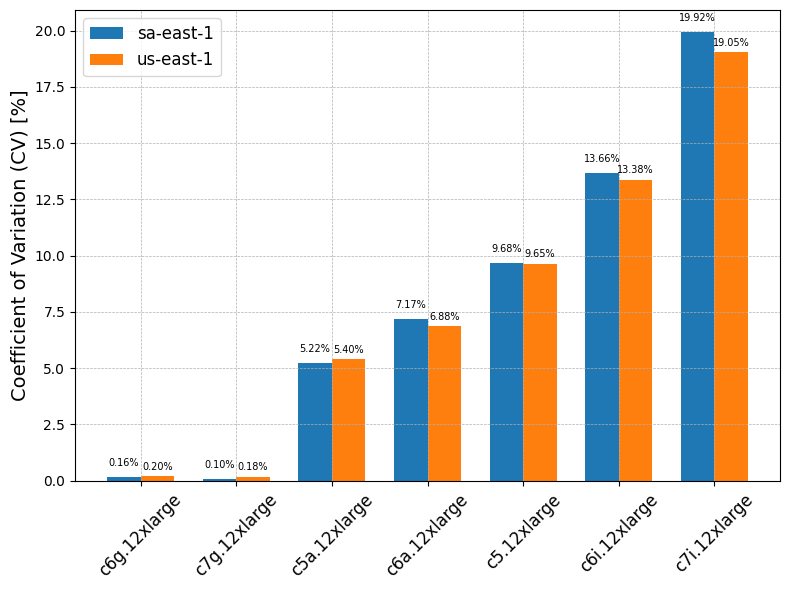

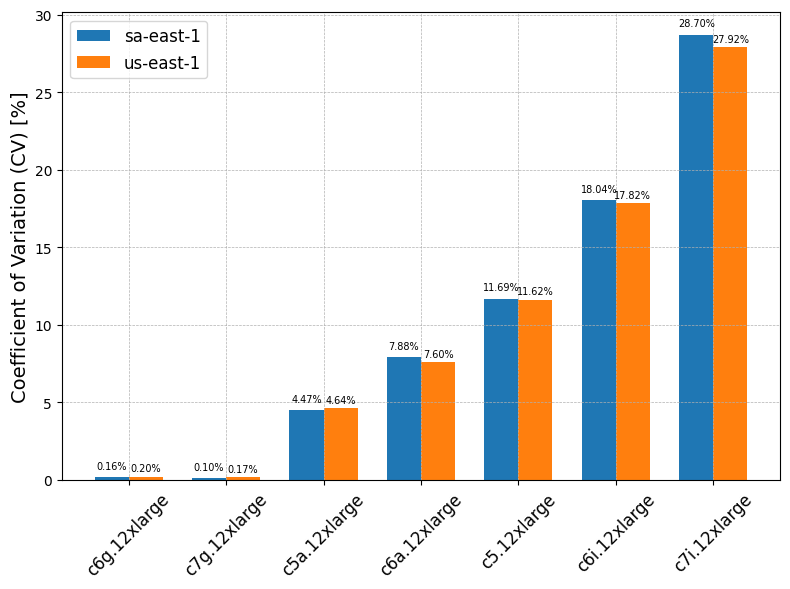

In [32]:
df_sa_cv = calculate_cv(df_sa, column='Time_in_Seconds')
df_us_cv = calculate_cv(df_us, column='Time_in_Seconds')
plot_CV(df_sa_cv, df_us_cv, save_to='graphs/performance_consistency_time.pdf')


df_sa_cv = calculate_cv(df_sa, column='Mops_Total')
df_us_cv = calculate_cv(df_us, column='Mops_Total')
plot_CV(df_sa_cv, df_us_cv, save_to='graphs/performance_consistency_mops.pdf')


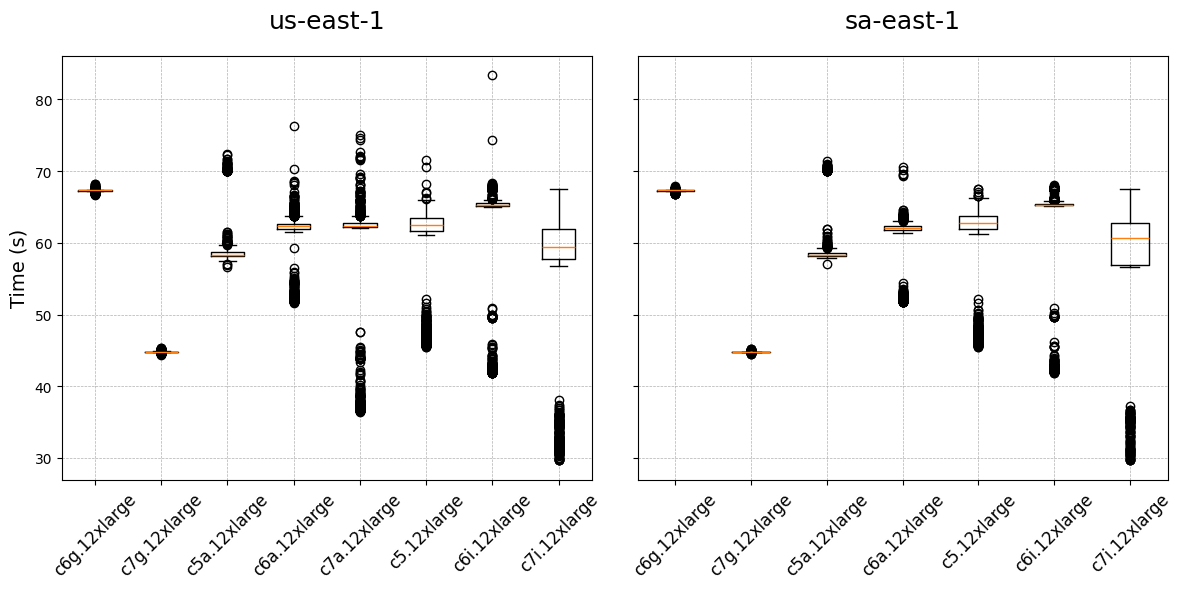

In [33]:
# Comparing the performance 

def generate_boxplot_per_instance(df_us, df_sa, column, title_us=None, title_sa=None, ylabel=None, save_to=None):
    """
    Generates two side-by-side boxplots per instance type based on a specified column for two dataframes.
    
    Parameters:
    df_us (pd.DataFrame): The first input dataframe (e.g., US region).
    df_sa (pd.DataFrame): The second input dataframe (e.g., SA region).
    column (str): The column to use for generating the boxplots.
    title_us (str): Title for the US region plot.
    title_sa (str): Title for the SA region plot.
    ylabel (str): Label for the y-axis.
    save_to (str): The file path to save the plot. If None, the plot will be shown.
    """
    
    # Create the figure and axis objects
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Generate boxplot for US region
    instance_types_us = df_us['Instance'].unique()
    data_to_plot_us = [df_us[df_us['Instance'] == instance][column] for instance in instance_types_us]
    box1 = ax1.boxplot(data_to_plot_us)
    ax1.set_xticklabels(instance_types_us, rotation=45, ha='center', fontsize=12)
    #ax1.set_xlabel('Instance Type', fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)
    ax1.set_title(title_us, fontsize=18, pad=20)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    


    # Generate boxplot for SA region
    instance_types_sa = df_sa['Instance'].unique()
    data_to_plot_sa = [df_sa[df_sa['Instance'] == instance][column] for instance in instance_types_sa]
    box2 = ax2.boxplot(data_to_plot_sa)
    ax2.set_xticklabels(instance_types_sa, rotation=45, ha='center', fontsize=12)
    #ax2.set_xlabel('Instance Type', fontsize=14)
    ax2.set_title(title_sa, fontsize=18, pad=20)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # centralize x-ticks
    

    # Adjust layout for better fit
    plt.tight_layout()
    
    # Save the plot to a file if a path is specified, otherwise show the plot
    if save_to:
        fig.savefig(save_to, dpi=300, bbox_inches='tight')
    else:
        plt.show()


df_sa = clean_data(load_data('results_sa-east-1.csv'))
df_us = clean_data(load_data('results_us-east-1.csv'))

# order by architecture and instance type

df_sa = df_sa.sort_values(by=['Architecture', 'Instance'])
df_us = df_us.sort_values(by=['Architecture', 'Instance'])

generate_boxplot_per_instance(df_us, df_sa, column='Time_in_Seconds', title_us='us-east-1', title_sa='sa-east-1', ylabel='Time (s)', save_to='graphs/performance_time.pdf')


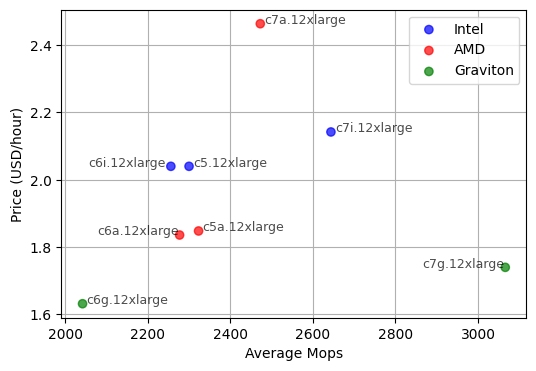

In [34]:


def plot_price_vs_average_mops(dataframe, save_to=None): 

    # Calculate the average Mops_Total per Instance
    average_mops = dataframe.groupby('Instance')['Mops_Total'].mean().reset_index()
    average_mops.columns = ['Instance', 'Average_Mops_Total']    

    # Merge the average Mops_Total back with the original data to get the Price
    merged_data = pd.merge(dataframe[['Instance', 'Price', 'Architecture']], average_mops, on='Instance').drop_duplicates()
    # Create a column color based on the architecture
    
    
    # create a column color based on the architecture
    #merged_data['color'] = merged_data['Architecture'].apply(lambda x: 'blue' if x == 'Intel' else 'red' if x == 'AMD' else 'green')
    merged_data['Architecture'] = merged_data['Architecture'].apply(lambda x: 'Intel' if x == 'Intel' else 'AMD' if x == 'AMD' else 'Graviton')
    color_map = {'Intel': 'blue', 'AMD': 'red', 'Graviton': 'green'}
    merged_data['color'] = merged_data['Architecture'].map(color_map)
    # Generate the scatter plot
    plt.figure(figsize=(6, 4))

    for arch in color_map:
        subset = merged_data[merged_data['Architecture'] == arch]
        plt.scatter(subset['Average_Mops_Total'], subset['Price'], c=subset['color'], alpha=0.7, label=arch)
    #plt.scatter(merged_data['Average_Mops_Total'], merged_data['Price'], c=merged_data['color'], alpha=0.7, label=merged_data['Architecture'])

    # Annotate each point with the Instance name
    for i, row in merged_data.iterrows():
        x_pos = row['Average_Mops_Total'] + 10
        y_pos = row['Price']
       
        if row['Instance'] == 'c6i.12xlarge':
            x_pos = row['Average_Mops_Total'] - 200
        
        if row['Instance'] == 'c6a.12xlarge':
            x_pos = row['Average_Mops_Total'] - 200
        
        if row['Instance'] == 'c7g.12xlarge':
            x_pos = row['Average_Mops_Total'] - 200
            
        plt.annotate(row['Instance'], (x_pos, y_pos), fontsize=9, alpha=0.7)

    #plt.title('Price vs Average Mops_Total per Instance')
    plt.xlabel('Average Mops')
    plt.ylabel('Price (USD/hour)')
    plt.grid(True)
    #plt.show()
    plt.legend()
        
    # Show the plot
    #plt.show()
    if save_to:
        plt.savefig(save_to, dpi=300, bbox_inches='tight')




df_us = clean_data(load_data('results_us-east-1.csv'))
df_us = df_us[(df_us['Market'] == 'ondemand')]

df_us = df_us.sort_values(by=['Architecture', 'Instance'])


#plot_performance_price_with_error(df_us, column="Mops_Total", save_to='graphs/performance_price.pdf')
plot_price_vs_average_mops(df_us, save_to='graphs/price_vs_mops.pdf')

In [35]:
def print_timeline(df, save_to=None):
    
    # Create subplots: 3 rows, first two rows with 3 columns, last row with 1 column
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    
    # Flatten the 2D array of axes to 1D for easier iteration
    axs = axs.flatten()

    for i, instance_type in enumerate(df['Instance'].unique()):
        instance_df = df[df['Instance'] == instance_type]
        axs[i].scatter(instance_df['End_Time'], instance_df['Mops_Total'])
        axs[i].set_title(f'Instance ID: {instance_type}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Mops_Total')
        axs[i].tick_params(axis='x', rotation=45)
    
    # Hide the last empty subplot
    #fig.delaxes(axs[7])
    
    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, dpi=300, bbox_inches='tight')
    
    #plt.show()



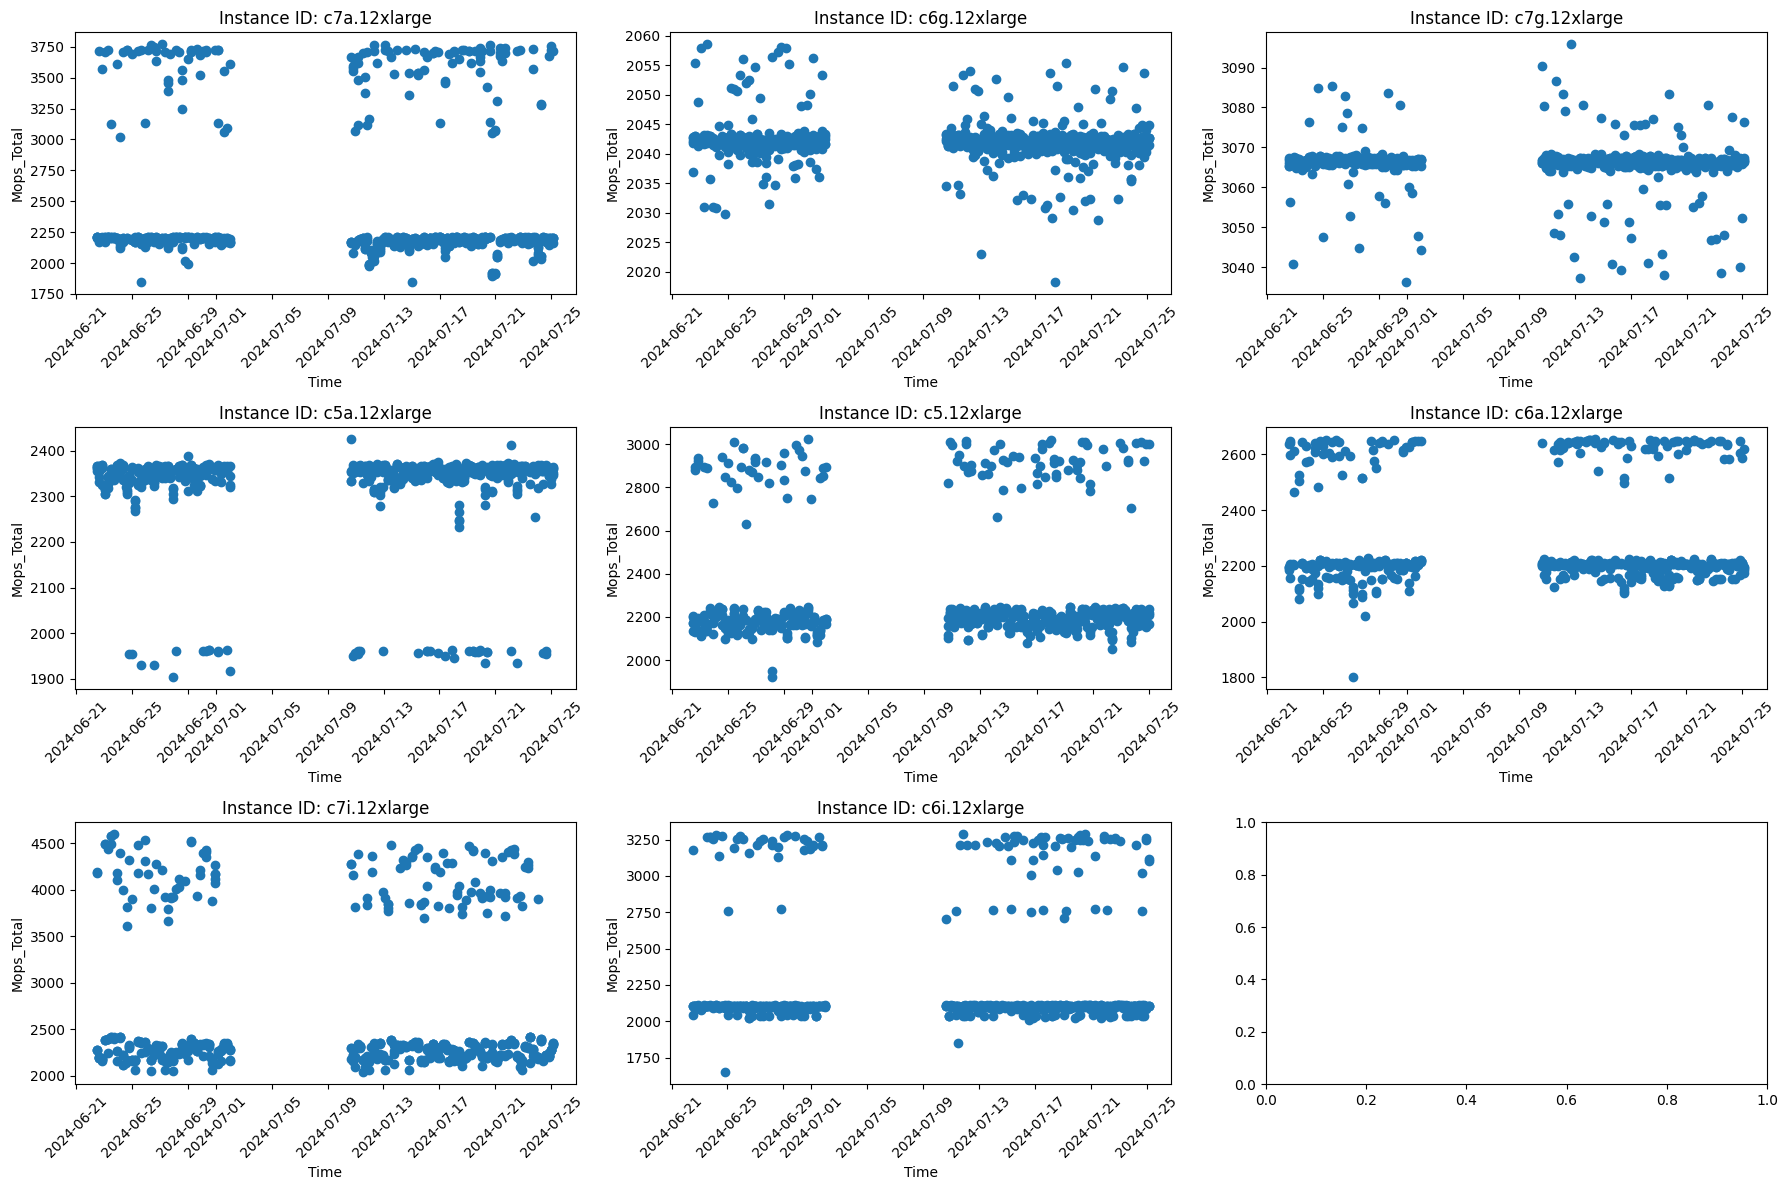

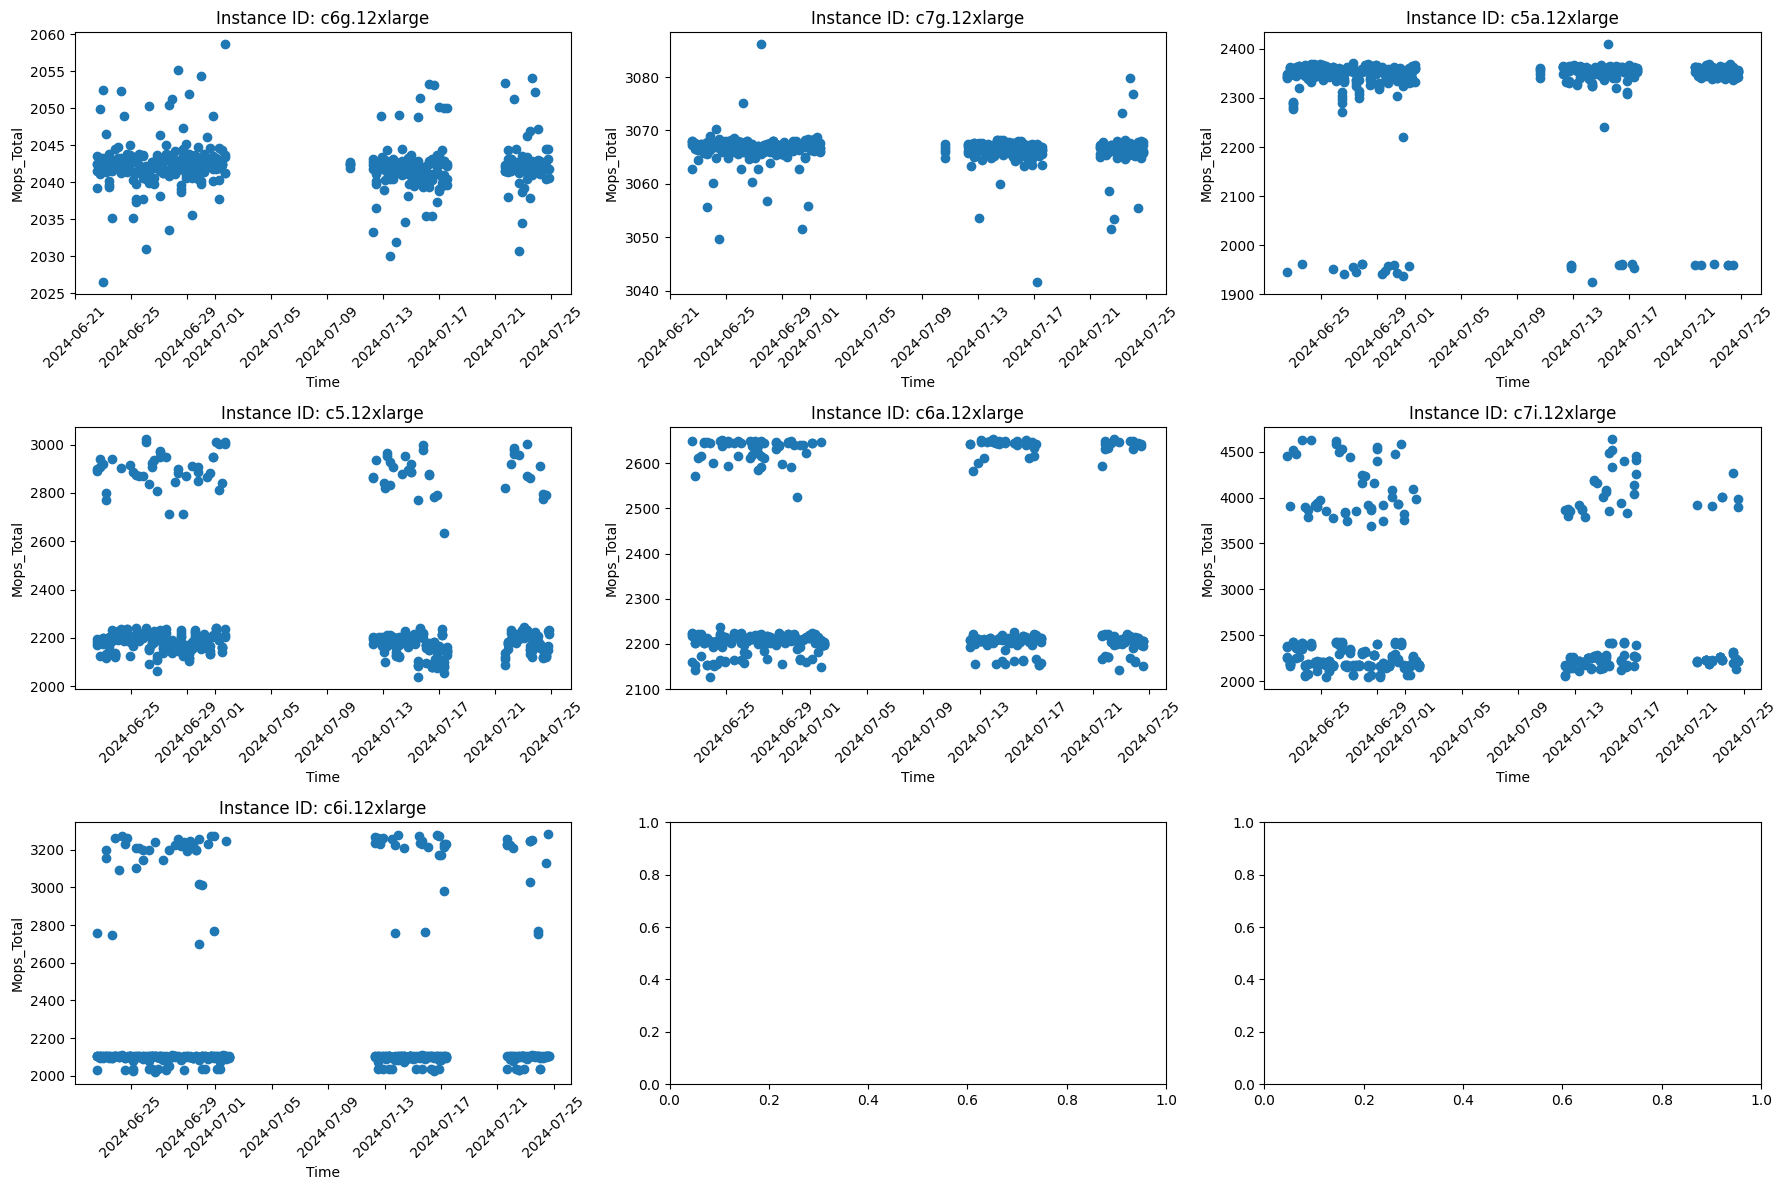

In [36]:
df_us = clean_data(load_data('results_us-east-1.csv'))
df_sa = clean_data(load_data('results_sa-east-1.csv'))

df_us = df_us.query("Market == 'ondemand'")
df_sa = df_sa.query("Market == 'ondemand'")


#df_us = df_us[(df_us['End_Time'] > pd.to_datetime('2024-06-24 12:00:00')) & (df_us['End_Time'] < pd.to_datetime('2024-06-24 18:00:00'))]
#df_us = df_us.query("Market == 'ondemand' & Instance == 'c6i.12xlarge'")
print_timeline(df_us, save_to='graphs/timeline_us.pdf')
print_timeline(df_sa, save_to='graphs/timeline_sa.pdf')


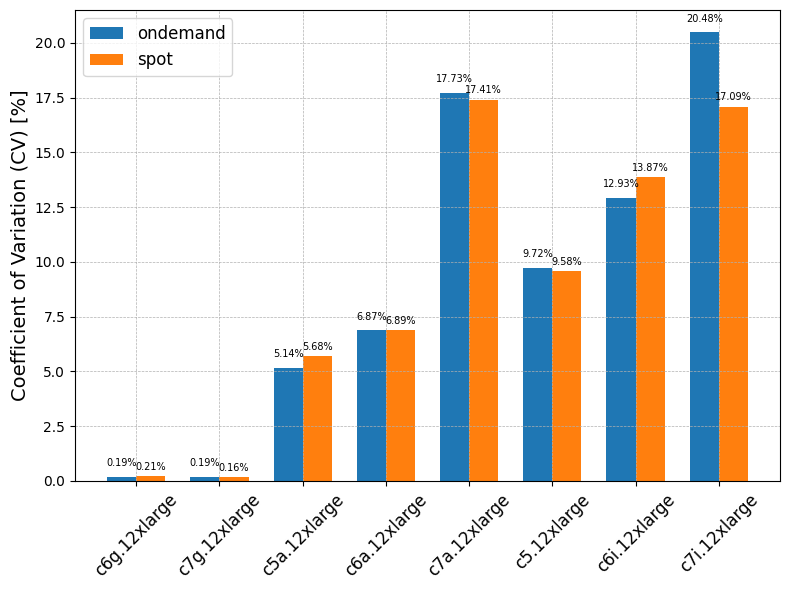

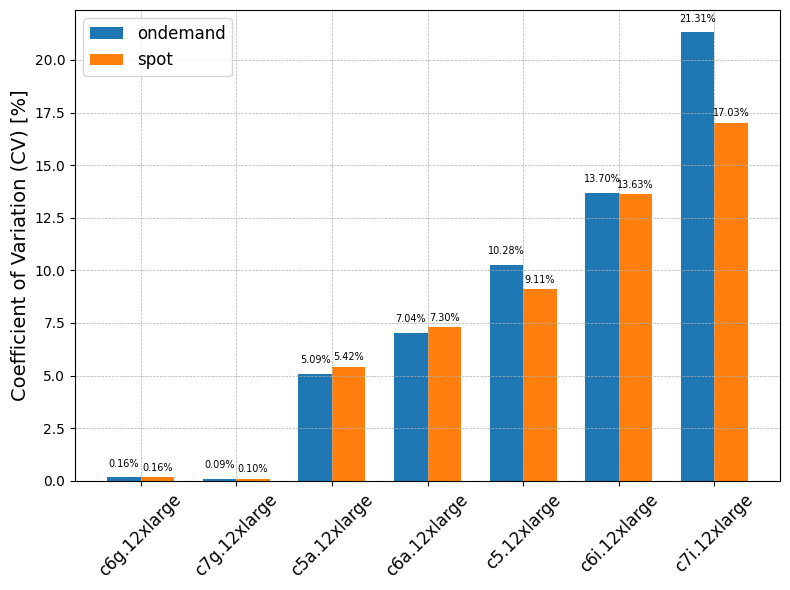

In [37]:
def plot_CV_market(df_ondemand, df_spot, save_to=None):
    df_ondemand = df_ondemand.reset_index(level='Market', drop=True).to_frame('ondemand')
    df_spot = df_spot.reset_index(level='Market', drop=True).to_frame('spot')

    # Combine the two DataFrames
    df_cv = df_ondemand.join(df_spot)
    
    # Sort the DataFrame by architecture and instance type
    df_cv['Architecture'] = df_cv.index.to_series().apply(get_architecture)
    df_cv = df_cv.sort_values(by=['Architecture'])
    
    #display(df_cv)
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    # Bar width
    bar_width = 0.35

    # Positions of the bars on the x-axis
    index = range(len(df_cv))

    # Bar plots with custom colors
    bar1 = ax.bar(index, df_cv['ondemand'], bar_width, label='ondemand', color='#1f77b4')
    bar2 = ax.bar([i + bar_width for i in index], df_cv['spot'], bar_width, label='spot', color='#ff7f0e')

    # Adding labels, title, and legend
    #ax.set_xlabel('Instance Type', fontsize=14)
    ax.set_ylabel('Coefficient of Variation (CV) [%]', fontsize=14)
    #ax.set_title('Performance Consistency across Regions (CV)', fontsize=16)
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(df_cv.index, rotation=45, ha='center', fontsize=12)
    ax.legend(fontsize=12)

    # Adding gridlines for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adding values in the middle of the bars
    for i in index:
        ax.text(i, df_cv['ondemand'].iloc[i] + 0.4, f'{df_cv["ondemand"].iloc[i]:.2f}%', ha='center', va='bottom', fontsize=7)
        ax.text(i + bar_width, df_cv['spot'].iloc[i] + 0.2, f'{df_cv["spot"].iloc[i]:.2f}%', ha='center', va='bottom', fontsize=7)

    # Adjust layout for better fit
    plt.tight_layout()
    plt.show()
    if save_to:
        fig.savefig(save_to)


df_us = clean_data(load_data('results_us-east-1.csv'))
df_us_ondemand = df_us.query("Market == 'ondemand'")
df_us_spot = df_us.query("Market == 'spot'")

df_us_ondemand = calculate_cv(df_us_ondemand, column='Time_in_Seconds', group_by=['Instance', 'Market'])
df_us_spot = calculate_cv(df_us_spot, column='Time_in_Seconds', group_by=['Instance', 'Market'])

plot_CV_market(df_us_ondemand, df_us_spot, save_to='graphs/performance_consistency_market.pdf')


df_sa = clean_data(load_data('results_sa-east-1.csv'))
df_sa_ondemand = df_sa.query("Market == 'ondemand'")
df_sa_spot = df_sa.query("Market == 'spot'")
df_sa_ondemand = calculate_cv(df_sa_ondemand, column='Time_in_Seconds', group_by=['Instance', 'Market'])
df_sa_spot = calculate_cv(df_sa_spot, column='Time_in_Seconds', group_by=['Instance', 'Market'])

plot_CV_market(df_sa_ondemand, df_sa_spot, save_to='graphs/performance_consistency_market_sa.pdf')


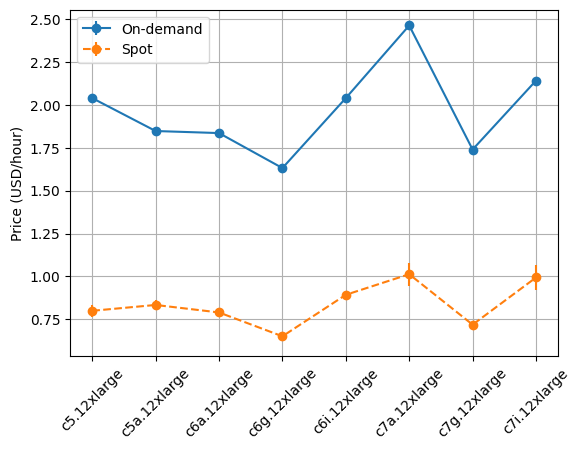

In [38]:
def line_plot_price(df, save_to=None):
    df = df.sort_values(by=['Architecture', 'Instance'])
    grouped = df.groupby(['Instance', 'Market'])['Price']
    mean_df = grouped.mean().unstack()
    std_df = grouped.std().unstack()

    fig = plt.figure(figsize=(6, 4))
    
    for market in mean_df.columns:
        marker = '-o' if market == 'ondemand' else '--o'
        label = 'On-demand' if market == 'ondemand' else 'Spot'
        
        plt.errorbar(mean_df.index, mean_df[market], yerr=std_df[market], fmt=marker, label=label)

    plt.ylabel('Price (USD/hour)')
    #plt.title('Average Price per VM (us-east-1)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)

    if save_to:
        plt.savefig(save_to, dpi=300, bbox_inches='tight')

df_us = clean_data(load_data('results_us-east-1.csv'))
line_plot_price(df_us, save_to='graphs/price_us.pdf')

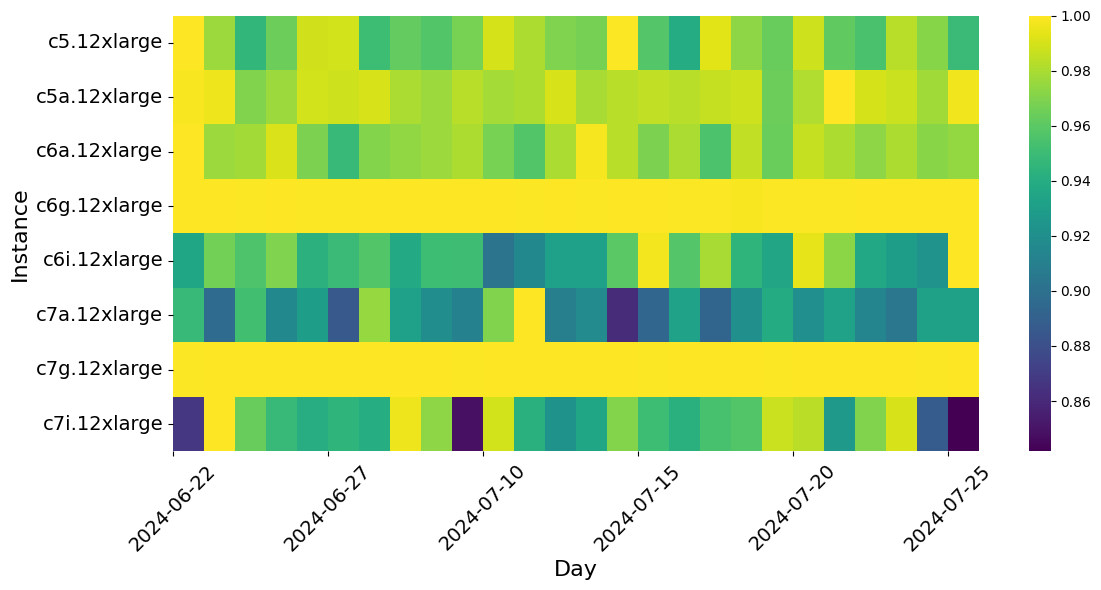

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def print_performance_heatmap(df, save_to=None):
    # short by architecture and instance
    df = df.sort_values(by=['Architecture', 'Instance'])

    df['Day'] = df['End_Time'].dt.date

    
    grouped = df.groupby(['Instance', 'Day'])['Mops_Total'].mean().unstack()

    # short by instance

    #print(grouped)

    # Normalize the performance (min-max scaling) per instance
    normalized_df = grouped.apply(lambda x: x / x.max(), axis=1)

    #print(normalized_df)

    # Drop days (columns) with missing values after normalization
    normalized_df = normalized_df.dropna(axis=1)

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(normalized_df, annot=False, cmap='viridis')

    plt.ylabel('Instance', fontsize=16)
    plt.xlabel('Day', fontsize=16)
    #plt.title('Normalized Performance per Instance per Day', fontsize=18)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    # show days on the x-axis every 5 days
    plt.xticks(np.arange(0, len(normalized_df.columns), 5), normalized_df.columns[::5])

    if save_to:
        plt.savefig(save_to, dpi=300, bbox_inches='tight')
    else:
        plt.show()
# Example usage:
df = clean_data(load_data('results_us-east-1.csv'))
print_performance_heatmap(df, save_to='graphs/performance_heatmap.pdf')
#df['Day'] = df['End_Time'].dt.date
#grouped = df.groupby(['Instance', 'Day'])['Mops_Total'].mean().unstack()